### imports

In [51]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
import pyarrow

## 1. Recommendation Engine with PySpark

In [52]:
# Inicializa a sessão Spark
spark = SparkSession.builder.appName("PMBD - Product_Recommendation") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")  # Pode ser ajustado para "INFO" durante o desenvolvimento

In [53]:
print(spark.sparkContext._jsc.sc().isStopped())  # False -> tudo bem; True -> Spark está desligado

False


In [54]:
data_dir = "../data/"
dataRaw_dir = data_dir + "raw/"

schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", LongType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

df = spark.read.parquet(dataRaw_dir + "ec_total.parquet", schema=schema).limit(10000)

In [55]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [56]:
df.show(5, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+
|2019-11-17 08:43:00|view      |2501799   |2053013564003713919|appliances.kitchen.oven      |elenberg|46.31  |563237118|4368d099-6d19-47cb-95f8-1a235bc2d701|
|2019-11-17 08:43:00|view      |6400335   |2053013554121933129|computers.components.cpu     |intel   |435.28 |551129779|4db2c365-ee85-4437-87ad-23d70bfc01a9|
|2019-11-17 08:43:00|view      |3701538   |2053013565983425517|appliances.environment.vacuum|irobot  |1878.81|539845715|bf7d95c0-69e1-40ff-817b-7118652f018b|
|2019-11-17 08:43:00|view      |26400266  |205301356

## 2. Exploratory Data Analysis

In [57]:
# Null values

df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|         2977| 1409|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



In [58]:
# Number of events

df.groupBy('event_type').count().show()

+----------+-----+
|event_type|count|
+----------+-----+
|      view| 9014|
|  purchase|  334|
|      cart|  652|
+----------+-----+



<Axes: ylabel='count'>

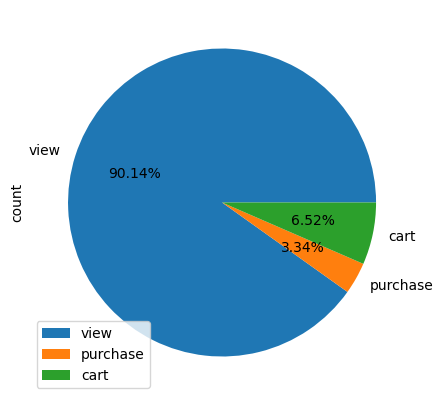

In [59]:
# Plot events distribution

events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [60]:
df.select(F.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                      4743|
+--------------------------+



<font size=3>Verificar se todos os produtos pertencem a uma única categoria, agrupando os produtos pelo seu ID, recolhendo os IDs das suas categorias em um conjunto e imprimindo o número de produtos que pertencem a uma única categoria.

In [61]:
df.groupby('product_id').agg(F.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()

4743

In [62]:
df.select(F.countDistinct("category_id")).show()

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        399|
+---------------------------+



In [63]:
df.drop_duplicates(subset=['category_id']).select(F.count("category_code")).show()

+--------------------+
|count(category_code)|
+--------------------+
|                 177|
+--------------------+



In [64]:
df.select(F.countDistinct("category_code")).show()

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          106|
+-----------------------------+



In [65]:
df.select(F.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                   5891|
+-----------------------+



In [66]:
df.select(F.countDistinct("user_session")).show()

# 13.8m sessions

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                        5931|
+----------------------------+



<Axes: xlabel='date'>

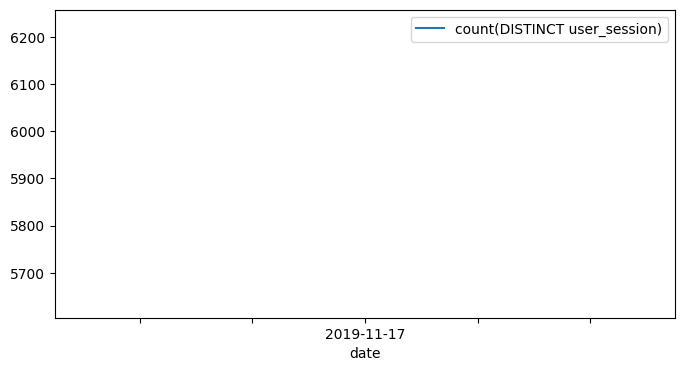

In [67]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

#TODO: Analisar o tempo médio de cada sessão

In [68]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))
interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|571912940|   2800596|    1|   15|     NULL|
|570589069|   3200173| NULL|    9|     NULL|
|515078645|   3601537|    1|    7|     NULL|
|525030988|  16500024| NULL|    4|     NULL|
|516466398|  13200069|    2|    4|     NULL|
|558050400|   1004870| NULL|    4|     NULL|
|559251309|   1600546|    2|    4|     NULL|
|513467417|   3700797| NULL|    3|     NULL|
|571350753|  17301612| NULL|    3|     NULL|
|515472801|  12717842|    3|    3|     NULL|
|518599372|  12710992|    1|    3|     NULL|
|560020069|   1004246|    1|    3|     NULL|
|529846623|  20000099|    3|    3|     NULL|
|514812405|   8800920|    1|    3|     NULL|
|524108308|   1004781|    2|    2|     NULL|
|553642686|   1004565|    3|    2|        1|
|566044802|  12709380|    1|    2|        1|
|516240916|   3800879|    4|    2|     NULL|
|560825845|   1801555| NULL|    2|        1|
|531913733

Os dados revelam um número significativo de pares utilizador-produto com um grande número de adições ao carrinho, mas muito poucas visualizações e compras.

Uma análise adicional mostra que muitos desses eventos de adição ao carrinho ocorreram durante a mesma sessão, o que pode ser devido a utilizadores a adicionar e remover repetidamente o produto.

No entanto, os dados não contêm informações sobre eventos de remoção do carrinho, por isso devemos restringir o número de adições ao carrinho a uma por sessão para cada par utilizador-produto.

## 3. Preprocess

In [69]:
def preprocess(df):
    
    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))
    
    # Limit the number of carts to 1 per session for each user-product pair
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])
    df = df.union(cart_df)
    
    # Split category codes into sub categories
    #df = df.withColumn('category', split(df['category_code'], '\.').getItem(0)) \
    #   .withColumn('sub_category', split(df['category_code'], '\.').getItem(1)) \
    #   .withColumn('sub_sub_category', split(df['category_code'], '\.').getItem(2))

    return df

In [70]:
df = preprocess(df)
df.show(5, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+----------+
|event_time         |event_type|product_id|category_id        |category_code                |brand   |price  |user_id  |user_session                        |date      |
+-------------------+----------+----------+-------------------+-----------------------------+--------+-------+---------+------------------------------------+----------+
|2019-11-17 08:43:00|view      |2501799   |2053013564003713919|appliances.kitchen.oven      |elenberg|46.31  |563237118|4368d099-6d19-47cb-95f8-1a235bc2d701|2019-11-17|
|2019-11-17 08:43:00|view      |6400335   |2053013554121933129|computers.components.cpu     |intel   |435.28 |551129779|4db2c365-ee85-4437-87ad-23d70bfc01a9|2019-11-17|
|2019-11-17 08:43:00|view      |3701538   |2053013565983425517|appliances.environment.vacuum|irobot  |1878.81|539845715|bf7d95c0-69e1-40ff-817b-7118652f018

## 4. Feature Engineering

Podemos extrair várias características para utilizadores, produtos e categorias utilizando os dados comportamentais:

- **Visualizações/carrinhos/compras**: O número de vezes que um utilizador interagiu com um produto.

- **Produtos distintos visualizados/adicionados ao carrinho/comprados**: O número de produtos únicos que um utilizador visualizou, adicionou ao carrinho ou comprou.

- **Preço médio (relativo) visualizado/comprado**: O preço médio dos produtos que um utilizador visualizou ou comprou.

- **Taxas de interação**: São características derivadas que fornecem informações sobre o comportamento dos utilizadores, como a taxa de compras por visualização, carrinho por visualização e compras por carrinho.

In [71]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [72]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    df = df.join(products, on='category_id')
    
    return df

In [73]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

Alguns produtos e categorias têm muito poucas interações, o que torna as suas taxas de interação pouco fiáveis. Por exemplo, um produto que foi visualizado apenas 2 vezes e comprado 1 vez teria uma taxa de compras por visualização de 0.5, o que é muito elevado. Por isso, é importante aplicar *smoothing* para evitar *overfitting* em amostras pequenas.

O *smoothing* funciona ao calcular uma média ponderada entre a taxa do produto e a taxa da categoria. O peso dado à taxa do produto depende do número de interações — quanto mais interações, maior o peso. O mesmo tipo de *smoothing* é aplicado às categorias, usando as taxas médias globais de interação.

In [74]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting
    
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    
    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))
    
    return categories

In [75]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting
    
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):
    
    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')
    
    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))
    
    products = products.drop(category_rate)
    return products

Devemos calcular o preço relativo de cada produto em relação à sua categoria, escalando o seu preço com base na mediana e no intervalo interquartil (IQR) dos preços dessa categoria. A mediana é usada como medida de tendência central e o IQR como medida de variabilidade.

Este escalamento permite compensar diferenças nos intervalos de preços entre categorias, possibilitando uma comparação mais precisa e imparcial dos preços dos produtos. Os preços relativos serão usados para determinar se os utilizadores tendem a interagir com produtos mais baratos ou mais caros.

In [76]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):
    
    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [77]:
# Extract product and category features
products = product_features(df)
products.show(5, truncate=False)

+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|product_id|category_id        |category_code         |views|carts|purchases|price             |first_date         |last_date          |purchase_per_view  |cart_per_view      |purchase_per_cart|
+----------+-------------------+----------------------+-----+-----+---------+------------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|1002098   |2053013555631882655|electronics.smartphone|2    |0    |0        |370.64            |2019-11-17 08:43:42|2019-11-17 08:44:14|0.0                |0.0                |0.0              |
|1002100   |2053013555631882655|electronics.smartphone|2    |0    |1        |370.64000000000004|2019-11-17 08:43:05|2019-11-17 08:44:08|0.5                |0.0                |1.0              |
|1002101   |2053013555631

In [78]:
categories = category_features(df)
categories.show(5, truncate=False)

+-------------------+-------------+------------------+-----+-----+---------+-----------------+-------------+-----------------+------------------+
|category_id        |category_code|number_of_products|views|carts|purchases|purchase_per_view|cart_per_view|purchase_per_cart|average_price     |
+-------------------+-------------+------------------+-----+-----+---------+-----------------+-------------+-----------------+------------------+
|2053013564968403895|NULL         |4                 |5    |0    |0        |0.0              |0.0          |0.0              |37.31             |
|2173216765583032544|apparel.shirt|1                 |1    |0    |0        |0.0              |0.0          |0.0              |102.71            |
|2053013563139687243|NULL         |7                 |8    |0    |0        |0.0              |0.0          |0.0              |195.03142857142856|
|2053013558836331105|NULL         |3                 |4    |0    |0        |0.0              |0.0          |0.0             

In [79]:
# Calculate relative prices and append it to the main dataframe and product features
relative_prices = calculate_relative_price(products)
relative_prices.show(5, truncate=False)

+----------+-------------------+
|product_id|relative_price     |
+----------+-------------------+
|8600156   |0.0                |
|8500346   |0.5851960640328976 |
|8500125   |-0.759024820091056 |
|8500187   |-0.3619033631957703|
|8500284   |-0.2297841092671465|
+----------+-------------------+
only showing top 5 rows



In [80]:
df = df.join(relative_prices, on='product_id')
df.show(5, truncate=False)

+----------+-------------------+----------+-------------------+--------------------------+-----+------+---------+------------------------------------+----------+-------------------+
|product_id|event_time         |event_type|category_id        |category_code             |brand|price |user_id  |user_session                        |date      |relative_price     |
+----------+-------------------+----------+-------------------+--------------------------+-----+------+---------+------------------------------------+----------+-------------------+
|8600156   |2019-11-17 08:43:31|view      |2053013552226107603|appliances.environment.fan|tefal|55.32 |525229920|d55eec94-c444-4fac-9e1e-c0922dfb1993|2019-11-17|0.0                |
|8500346   |2019-11-17 08:44:30|view      |2053013552259662037|NULL                      |NULL |689.05|543466616|a612382a-e8b5-4eb4-9cb0-904a6aecb91a|2019-11-17|0.5851960640328976 |
|8500125   |2019-11-17 08:44:14|view      |2053013552259662037|NULL                      |

In [81]:
products = products.join(relative_prices, on='product_id')
products.show(5, truncate=False)

+----------+-------------------+--------------------------+-----+-----+---------+------+-------------------+-------------------+-----------------+-------------+-----------------+-------------------+
|product_id|category_id        |category_code             |views|carts|purchases|price |first_date         |last_date          |purchase_per_view|cart_per_view|purchase_per_cart|relative_price     |
+----------+-------------------+--------------------------+-----+-----+---------+------+-------------------+-------------------+-----------------+-------------+-----------------+-------------------+
|8600156   |2053013552226107603|appliances.environment.fan|1    |0    |0        |55.32 |2019-11-17 08:43:31|2019-11-17 08:43:31|0.0              |0.0          |0.0              |0.0                |
|8500346   |2053013552259662037|NULL                      |1    |0    |0        |689.05|2019-11-17 08:44:30|2019-11-17 08:44:30|0.0              |0.0          |0.0              |0.5851960640328976 |
|8500

In [82]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [83]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [84]:
# Extract user features

users = user_features(df)
users.show(5, truncate=False)

+---------+-----+-----+---------+------------------------+------------------------+---------------------------+--------------------+-----------------------+-------------------------+----------------------------+-------------------+-------------------+-----------------+-------------+-----------------+
|user_id  |views|carts|purchases|distinct_products_viewed|distinct_products_carted|distinct_products_purchased|average_price_viewed|average_price_purchased|avg_relative_price_viewed|avg_relative_price_purchased|first_date         |last_date          |purchase_per_view|cart_per_view|purchase_per_cart|
+---------+-----+-----+---------+------------------------+------------------------+---------------------------+--------------------+-----------------------+-------------------------+----------------------------+-------------------+-------------------+-----------------+-------------+-----------------+
|548193532|2    |0    |0        |1                       |0                       |0          

In [85]:
# Top 50 products in terms of purchases

products.sort('purchases', ascending=False).toPandas().head(50)

,category_id,product_id,category_code,views,carts,purchases,price,first_date,last_date,purchase_per_view,cart_per_view,purchase_per_cart,relative_price
0,2053013554658804075,4804056,electronics.audio.headphone,61,13,9,169.350000,2019-11-17 08:43:04,2019-11-17 08:44:39,0.048348,0.085498,0.556144,1.621774
1,2053013555631882655,1004856,electronics.smartphone,72,10,6,128.420000,2019-11-17 08:43:00,2019-11-17 08:44:39,0.061441,0.090113,0.660709,-0.403663
2,2053013555631882655,1005160,electronics.smartphone,31,3,6,202.300000,2019-11-17 08:43:06,2019-11-17 08:44:36,0.063890,0.086653,0.707430,-0.284234
3,2053013555631882655,1004870,electronics.smartphone,33,7,4,298.259545,2019-11-17 08:43:00,2019-11-17 08:44:40,0.061771,0.090480,0.660732,-0.129113
4,2053013555631882655,1005105,electronics.smartphone,47,4,4,1363.965455,2019-11-17 08:43:01,2019-11-17 08:44:35,0.060934,0.086272,0.680756,1.593630
5,2053013555631882655,1004836,electronics.smartphone,26,6,4,245.178333,2019-11-17 08:43:03,2019-11-17 08:44:39,0.062189,0.090084,0.667407,-0.214920
6,2053013555631882655,1005177,electronics.smartphone,13,1,4,849.160000,2019-11-17 08:43:01,2019-11-17 08:44:33,0.062966,0.086207,0.700779,0.761433
7,2053013555631882655,1004833,electronics.smartphone,26,2,4,179.282187,2019-11-17 08:43:02,2019-11-17 08:44:35,0.062189,0.086084,0.694105,-0.321443
8,2053013555631882655,1004249,electronics.smartphone,25,6,4,788.157429,2019-11-17 08:43:00,2019-11-17 08:44:39,0.062249,0.090171,0.667407,0.662821
9,2053013561218695907,4100346,None,8,0,4,395.350000,2019-11-17 08:43:07,2019-11-17 08:44:39,0.043586,0.070994,0.544709,-0.442687


## 5.Collaborative Filtering

A filtragem colaborativa permite recomendar produtos a utilizadores com base nas suas interações e nas de utilizadores semelhantes. O algoritmo **ALS (Alternating Least Squares)** aprende padrões entre utilizadores e produtos a partir da matriz de interações.

Para dar mais relevância às interações recentes, aplicamos uma **função de decaimento exponencial** com meia-vida de 20 dias. Assim, interações mais antigas têm menos peso, o que torna as recomendações mais atuais e personalizadas.

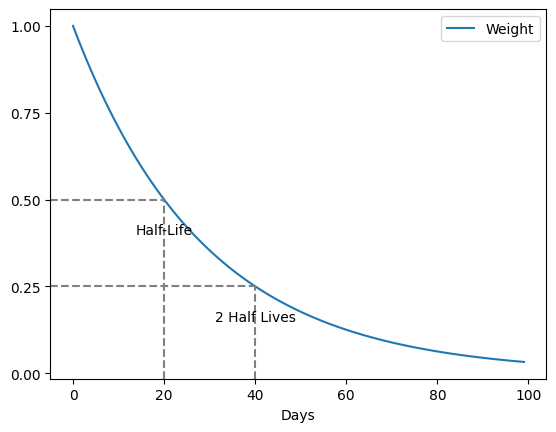

In [86]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df_halfLife = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df_halfLife.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [87]:
# Get the timestamp of the most recent event in the df
last_date = df.agg(max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [88]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

A matriz de interações é construída atribuindo pesos a cada tipo de interação do utilizador. Estas interações são somadas, após serem ponderadas por uma **função de decaimento de meia-vida**, que valoriza eventos mais recentes.

O resultado é transformado com **logaritmo base 10** e limitado a um máximo de 100, para garantir escalabilidade, consistência e reduzir o impacto de outliers. A matriz final reflete a **força da relação** entre utilizadores e produtos.

In [89]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):
 
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))
    
    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))
    
    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [90]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [91]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+-------------------+
|  user_id|product_id|             views|             carts|         purchases|        interaction|
+---------+----------+------------------+------------------+------------------+-------------------+
|572491961|  39600013|2.9999249903576373|0.9999847572962283|     0.99999438424| 0.4149703931655363|
|521582010|   5100676| 2.999906137811334| 0.999969113710265|0.9999855595380028| 0.4149678202742627|
|553642686|   1004565| 2.999914962477611| 0.999963899235994|0.9999771360314702| 0.4149662993225336|
|512590947|   1307308|1.9999610911300105|0.9999887685115368|0.9999987966202023| 0.3979385383719496|
|571824666|   2601810|1.9999614922255562|0.9999883673892819|0.9999947853646685|0.39793782760562557|
|570907300|   4804056|1.9999310073748875| 0.999963899235994|0.9999935819911459|0.39793581380127924|
|524663200|   1801806|1.9999835538848938|0.9999935819911459|0.9999779382671306| 0.3979355559586916|


Depois de criar uma matriz de interações ponderada entre utilizadores e produtos, esta pode ser usada pelo algoritmo **ALS** para aprender fatores latentes de ambos. Estes fatores permitem gerar **recomendações personalizadas**.

Para otimizar o desempenho do ALS, utiliza-se uma **validação cruzada**, testando diferentes combinações de parâmetros. O objetivo é obter um modelo que recomende produtos com **precisão e relevância**, com base nas interações anteriores dos utilizadores.

In [98]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):
    # Remover dados nulos
    interaction_matrix = interaction_matrix.na.drop(subset=['interaction'])

    # Modelo ALS
    als = ALS(
        userCol='user_id', itemCol='product_id', ratingCol='interaction',
        nonnegative=True, coldStartStrategy='drop', implicitPrefs=True
    )

    # Reduzir grid para acelerar
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [10]) \
        .addGrid(als.regParam, [0.05]) \
        .addGrid(als.alpha, [1.0]) \
        .build()

    # Avaliador
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

    # CrossValidator
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=2)

    # Pipeline
    pipeline = Pipeline(stages=[cv])

    # Treinar
    pipeline_model = pipeline.fit(interaction_matrix)

    # Obter melhor modelo
    best_model = pipeline_model.stages[0].bestModel

    # Prever e avaliar
    predictions = best_model.transform(interaction_matrix)
    rmse = evaluator.evaluate(predictions)
    print(f"RMSE: {rmse:.4f}")

    # Parâmetros do melhor modelo
    regParam = best_model._java_obj.parent().getRegParam()
    rank = best_model._java_obj.parent().getRank()
    alpha = best_model._java_obj.parent().getAlpha()
    print(f"Melhor modelo -> rank: {rank}, regParam: {regParam}, alpha: {alpha}")

    return pipeline_model

In [99]:
interaction_matrix.count()

8065

In [100]:
model = cross_validate_als(interaction_matrix)

# Model with the lowest RMSE value 
bestModel = model.stages[0].bestModel

# Make predictions
predictions = bestModel.transform(interaction_matrix)

# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# Print the parameters of the model with the lowest RMSE value
regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

RMSE: 0.2146
Melhor modelo -> rank: 10, regParam: 0.05, alpha: 1.0
 rmse:0.214578101046998 mae:0.10543171417415834
rank:10 regParam:0.05 alpha:1.0


Depois de identificar o melhor conjunto de parâmetros, podemos treinar diretamente o modelo **ALS** sem recorrer novamente à validação cruzada. Esta abordagem é **mais eficiente**, poupando tempo e recursos ao gerar recomendações de produtos.

In [101]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):
    
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              alpha=1, regParam=0.005, rank=15, implicitPrefs=True, 
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)
    
    # Make predictions
    predictions = model.transform(test)
    
    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))
    
    return model

In [102]:
als_model = simple_als(interaction_matrix)

test rmse:0.061484397341134714 mae:0.050619718063908484


### 5.1. Recommend Products for Users

In [106]:
from pyspark.sql.functions import col
import random

# Obter todos os user_ids únicos
unique_users = interaction_matrix.select('user_id').distinct()

# Converter para uma lista de IDs
user_ids = [row['user_id'] for row in unique_users.collect()]

# Selecionar 3 IDs aleatórios
random_users = random.sample(user_ids, 3)

# Criar DataFrame com os utilizadores selecionados
user_subset_df = spark.createDataFrame([(user, 0) for user in random_users], ['user_id', 'product_id'])
user_subset_df.show()

+---------+----------+
|  user_id|product_id|
+---------+----------+
|542774690|         0|
|514314611|         0|
|531892135|         0|
+---------+----------+



In [107]:
# Gerar recomendações para os 3 utilizadores
recommendations = als_model.recommendForUserSubset(user_subset_df, 500)
recommendations.show(truncate=False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [108]:
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|542774690|[{4804056, 0.0306...|
|531892135|[{1004836, 2.0199...|
|514314611|[{1005160, 0.6861...|
+---------+--------------------+



In [116]:
recs_for_user_1 = spark.createDataFrame(recommendations.collect()[1][1])

In [117]:
random_users

[542774690, 514314611, 531892135]

In [124]:
user = random_users[0]

In [125]:
# Products with the highest number of interactions for the user
interactions.filter(col('user_id') == user).sort('purchases', ascending=False).show()

+---------+----------+------------------+-----+---------+
|  user_id|product_id|             views|carts|purchases|
+---------+----------+------------------+-----+---------+
|542774690|   1004857|0.9999719215153658|  0.0|      0.0|
+---------+----------+------------------+-----+---------+



Ao gerar recomendações, podemos melhorar os scores de filtragem colaborativa (CF) ao integrar **características adicionais** que tornam as sugestões mais relevantes e personalizadas. Esta função combina o **score CF**, a **taxa de conversão** dos produtos e os **hábitos de consumo** dos utilizadores.

Os três scores são normalizados (entre 0 e 1) e combinados através de uma **média ponderada**, onde o peso do score CF é geralmente superior. Após a combinação, os valores são reescalados à sua escala original.

- **Score CF**: Indica o grau de afinidade entre o utilizador e o produto, aprendido pelo algoritmo ALS.
- **Taxa de Conversão**: Mede a proporção de compras por visualizações de um produto, favorecendo os que mais facilmente geram vendas.
- **Hábitos de Consumo**: Representam a média dos preços relativos dos produtos comprados pelo utilizador. Também aplicamos um *spending booster*, que dá uma ligeira preferência a produtos ligeiramente acima do hábito de consumo, incentivando o aumento de receita.

Com a afinação dos pesos, geramos recomendações **mais eficazes**, alinhadas com o perfil e comportamento do utilizador.

In [129]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
    # Join the recommendations with products data
    recs = recs.join(products[['product_id', 'purchase_per_view', 'relative_price']], on='product_id')
    
    # Get the user's average relative price, ensuring no None value is returned
    user_data = users.filter(col('user_id') == user_id).select('user_id', 'avg_relative_price_purchased').collect()
    
    if user_data:
        user_avg_relative_price = user_data[0][1]
    else:
        # Define a default value if the user does not exist in the data
        user_avg_relative_price = 0  # Or any other default value you prefer
    
    # Check if user_avg_relative_price is None and assign a default value
    if user_avg_relative_price is None:
        user_avg_relative_price = 0  # Or another appropriate default value
    
    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', 
                           ((col('rating') * coef_als_score) + 
                            (col('purchase_per_view') * coef_conversion_rate) - 
                            abs(user_avg_relative_price + coef_spending_booster - col('relative_price')) * coef_spending_habit) / 
                            (coef_als_score + coef_conversion_rate + coef_spending_habit)
                          )
    
    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5
    
    return recs

In [130]:
recs_user = calculate_recommendation_scores_for_user(user, recs_for_user_1, products, users)

In [131]:
# Add all product features to the recommendations dataframe

#recs_user = recs_user.join(product_features, on='product_id', how='left')

In [132]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1003312|1.614751952789194...|0.060562952296427774| 0.11883739351125922| 0.07980873338634141|
|   1004850|3.155761568431997...|  0.0596226944752607| 0.09395580414154314| 0.07919471617409143|
|   1004246|6.538247319855944...| 0.06060707743510095| 0.13498326894165946| 0.07906027313305192|
|   1005279|4.658937765135514...| 0.05950321011759484| 0.09403016440083412| 0.07903912171016816|
|   1005280|6.48173558117724E-20| 0.05944346793876192| 0.09403016440083412| 0.07895946547172426|
|   1004653|1.971955444149943...|0.059562952296427774| 0.07364252113609537| 0.07809939578537514|
|   1002538|4.611736703274124...|  0.0596226944752607| 0.06898368923877718| 0.07794611042895314|
|   1002524|2.460289696309178.

Para melhorar a **relevância e novidade** das recomendações, podemos filtrar os resultados para incluir apenas produtos **não previamente interagidos**. Isto significa excluir produtos que o utilizador já visualizou, adicionou ao carrinho ou comprou, bem como produtos pelos quais demonstrou desinteresse.

Este processo permite criar secções dedicadas como **"Novidades para Si"** ou **"Descubra Algo Diferente"**, focadas em apresentar opções **frescas e inéditas**. Desta forma, o utilizador tem oportunidade de explorar novos produtos e evitar recomendações repetitivas.

Este passo de filtragem garante que as recomendações são mais **personalizadas** e **exploratórias**, promovendo uma melhor experiência de utilizador e aumentando a probabilidade de descoberta de algo novo e apelativo.

In [133]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == user), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1003312|1.614751952789194...|0.060562952296427774| 0.11883739351125922| 0.07980873338634141|
|   1004850|3.155761568431997...|  0.0596226944752607| 0.09395580414154314| 0.07919471617409143|
|   1004246|6.538247319855944...| 0.06060707743510095| 0.13498326894165946| 0.07906027313305192|
|   1005279|4.658937765135514...| 0.05950321011759484| 0.09403016440083412| 0.07903912171016816|
|   1005280|6.48173558117724E-20| 0.05944346793876192| 0.09403016440083412| 0.07895946547172426|
|   1004653|1.971955444149943...|0.059562952296427774| 0.07364252113609537| 0.07809939578537514|
|   1002538|4.611736703274124...|  0.0596226944752607| 0.06898368923877718| 0.07794611042895314|
|   1002524|2.460289696309178.

### 5.3. Recommend Products for Products

Quando um utilizador está a visualizar um produto específico, podemos melhorar a sua experiência de compra ao recomendar **produtos semelhantes**. Estas recomendações são focadas **no produto em si**, e não nas preferências individuais do utilizador.

Para tal, utilizamos o algoritmo **ALS**, que calcula fatores latentes dos produtos com base nas interações. Estes fatores refletem características intrínsecas dos produtos, permitindo compreender as suas **semelhanças subjacentes**.

Convertendo estes fatores em **vetores num espaço multidimensional**, aplicamos o algoritmo **Locality-Sensitive Hashing (LSH)** para identificar, de forma eficiente, vetores próximos — ou seja, produtos com **características semelhantes**.

Desta forma, conseguimos recomendar produtos que partilham atributos relevantes, sejam **alternativas dentro da mesma categoria** ou **itens complementares** de outras categorias.

Este tipo de recomendação ajuda os utilizadores a descobrir **novas opções relevantes**, enriquecendo a sua experiência e aumentando a diversidade dos produtos apresentados.

In [ ]:
product_vectors.select("product_id").show(truncate=False, n=5)

TypeError: 'Column' object is not callable

In [ ]:
break

In [135]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = als_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector

IndexError: list index out of range

O algoritmo **LSH (Locality-Sensitive Hashing)** é uma técnica utilizada para **pesquisa aproximada dos vizinhos mais próximos** em espaços de alta dimensão, com grande eficiência computacional.

O LSH funciona projetando aleatoriamente os dados de alta dimensão para um **espaço de menor dimensão**, através de funções de hash. O seu princípio baseia-se no facto de que **itens semelhantes têm maior probabilidade de cair no mesmo balde (bucket)**, enquanto itens diferentes tendem a ser separados em baldes distintos. Esta estratégia permite **reduzir drasticamente o espaço de procura**, limitando a busca aos candidatos que partilham o mesmo balde.

Os principais parâmetros do LSH são:

- **`numHashTables`**: Define o número de tabelas de hash utilizadas. Um número mais elevado de tabelas **melhora a precisão** da pesquisa, mas também **aumenta o custo computacional**.
- **`bucketLength`**: Controla o tamanho dos baldes. Baldes mais pequenos oferecem **maior precisão**, mas exigem mais recursos de processamento.

O LSH é, assim, uma solução eficaz para encontrar rapidamente produtos semelhantes em sistemas de recomendação com **grandes volumes de dados** e elevada dimensionalidade.

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)

# Find the nearest neighbors of a specific product
query = product_vectors.filter(col('product_id') == 5100067).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)


[Stage 1810:===========>                                            (1 + 4) / 5]



In [ ]:
# Print the most similar products, the first entry is the product itself

neighbors.select('product_id', 'distCol').show(truncate=False)

+----------+--------------------+

|product_id|distCol             |

+----------+--------------------+

|4804718   |0.0                 |

|21100167  |0.025623069311288733|

|25502487  |0.025659637965671916|

|26003465  |0.025748307147201683|

|6700761   |0.025778819882874466|

|25500824  |0.02607277901645369 |

|25500813  |0.026072779091103976|

|25506322  |0.026072780861647937|

|100013628 |0.02657481135260701 |

|26003258  |0.026648804565296433|

|24700415  |0.027346895368139734|

|4803569   |0.027793061863495686|

|11400293  |0.028604851003621326|

|100014545 |0.028888908744473692|

|100006176 |0.02912256504844651 |

|18000870  |0.02974081584017109 |

|21410359  |0.02975023186412197 |

|14300152  |0.03046315559933421 |

|27200822  |0.030504550469149565|

|26024054  |0.03087306632829267 |

+----------+--------------------+

only showing top 20 rows




Quando calculamos os **scores de recomendação para produtos**, utilizamos uma abordagem semelhante à usada nas recomendações para utilizadores. Medimos a **semelhança entre produtos** com base na **distância cosseno** e combinamos essa informação com outras características, como a **taxa de conversão** e o **preço relativo**.

A função funciona de forma similar ao processo de recomendação para utilizadores, mas com uma pequena diferença. Em vez de calcular os **hábitos de gasto dos utilizadores**, consideramos o **preço relativo** do produto que está a ser visualizado. Isso ajuda a encontrar produtos que apresentam **faixas de preço semelhantes**.

In [ ]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):
   
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
     
    # Scale distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Find the relative price of the chosen product
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = (product_relative_price + 5) / 10
    

    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price)) 

    # Remove the searched product from the recommendations
    recs = recs.filter(col('distCol') != 1)
    
    
    # Scale back distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))
    
    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = product_relative_price * 10 - 5
    
    return recs

In [ ]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)

In [ ]:
# Add all product features to the recommendations dataframe

#recs_product = recs_product.join(product_features, on='product_id', how='left')

In [ ]:
# Display recommendations with Pandas

recs_product.sort('recommendation_score', ascending=False).toPandas() \
    .style.bar(color='lightgreen', subset='distCol') \
    .bar(color='pink', subset='purchase_per_view') \
    .bar(color='tan', subset='relative_price') \
    .bar(color='lightblue', subset='recommendation_score')


### 5.3. Recommend Products to Users Viewing a Product

Ao combinar ambas as abordagens de recomendar produtos aos utilizadores e encontrar produtos semelhantes, podemos criar um sistema de recomendação mais **personalizado**. Isso permite sugerir produtos que são não só **relevantes para as preferências** do utilizador, mas também semelhantes ao produto que estão a visualizar no momento.

Utilizando o **filtragem colaborativa** e os **dados históricos do utilizador**, geramos recomendações adaptadas aos seus gostos individuais. Simultaneamente, utilizamos a **análise de semelhança de produtos**, considerando fatores como a **distância cosseno** e outras características relevantes. Isso permite sugerir produtos semelhantes ao que o utilizador está a explorar, criando uma experiência mais **personalizada e envolvente**.

Em essência, esta abordagem híbrida combina os benefícios das **recomendações personalizadas** e da **identificação de produtos semelhantes**, resultando num sistema de recomendação **abrangente** e **eficaz**.

In [ ]:
# Join the two recommendation dataframes, top 50 most similar products and top 500 recs for the user

recs_user = recs_user.withColumnRenamed('recommendation_score', 'recommendation_score_user')
recs_paired = recs_product.join(recs_user['product_id', 'recommendation_score_user'], on='product_id', how='left')

Ao encontrar os produtos mais semelhantes, é importante notar que nem todos terão uma **pontuação de recomendação** correspondente. Isto ocorre porque calculamos as pontuações apenas para os **top 500 produtos**, especificamente para os utilizadores. Como resultado, alguns dos **top 50 produtos semelhantes** podem não ter pontuações de utilizador disponíveis.

Para lidar com esta situação, é necessário atribuir **pontuações substitutas** para os produtos sem pontuações de utilizador. Uma abordagem simples seria preencher essas pontuações com uma versão ligeiramente reduzida da **pontuação mais baixa**. Isso garante que os produtos sem pontuações de utilizador ainda recebam alguma consideração no processo de recomendação.

In [ ]:
# Fill missing user-based recommendation scores with 10% less of the lowest recommendation score
min_user_score = recs_paired.select(min('recommendation_score_user')).collect()[0][0]
recs_paired = recs_paired.na.fill(min_user_score * 0.9)

# Calculate a paired score as the average of the recommendation score and user score, weighted equally
recs_paired = recs_paired.withColumn('paired_score', col('recommendation_score') * 0.5 + col('recommendation_score_user') * 0.5)


In [ ]:
# Add all product features to the recommendations dataframe

#recs_paired = recs_paired.join(product_features, on='product_id', how='left')

In [ ]:
recs_paired.sort('paired_score', ascending=False).toPandas()\
           .head(50).style.bar(color='lightblue', subset='recommendation_score')\
           .bar(color='pink', subset='recommendation_score_user')\
           .bar(color='lightgreen', subset='paired_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score,recommendation_score_user,paired_score
0,5100562,0.941451,0.604642,0.549967,0.785411,0.064123,0.424767
1,5100689,0.935476,0.477132,0.569910,0.769874,0.028087,0.398981
2,5100337,0.930818,0.331873,0.576471,0.752278,0.044496,0.398387
3,5100567,0.929342,0.358018,0.719742,0.768039,0.028087,0.398063
4,5100365,0.926568,0.524521,0.564277,0.766923,0.028087,0.397505
5,5100343,0.930533,0.455005,0.586391,0.765355,0.028087,0.396721
6,5100505,0.962303,0.234256,0.550111,0.765069,0.028087,0.396578
7,5100347,0.931093,0.299003,0.603361,0.751900,0.028087,0.389994
8,5100576,0.912073,0.353727,0.683804,0.750201,0.028087,0.389144
9,5100604,0.909871,0.465793,0.550085,0.746274,0.028087,0.387181


Em conclusão, o **motor de recomendação** que desenvolvemos combina **filtragem colaborativa** com características adicionais para gerar recomendações de produtos personalizadas e envolventes. Ao incorporar fatores como **taxas de conversão**, **hábitos de consumo** e **semelhança de produtos**, o objetivo é fornecer aos utilizadores sugestões relevantes, adaptadas às suas preferências.

Quando o motor de recomendação é **implementado**, ele aprende continuamente com as interações dos utilizadores e atualiza as recomendações em conformidade, dando mais peso às interações recentes. À medida que os utilizadores interagem com o sistema, o seu feedback influencia os pesos e a relevância de diferentes características, tornando as recomendações mais precisas e alinhadas com as preferências dos utilizadores ao longo do tempo. Essa natureza dinâmica assegura que as recomendações permaneçam relevantes e reflictam os interesses em evolução dos utilizadores.

Para avaliar o desempenho das nossas recomendações, podemos utilizar diversas **métricas** como **taxas de cliques**, **taxas de conversão** e **feedback dos utilizadores**. Essas métricas fornecem uma visão sobre a eficácia das recomendações e ajudam a avaliar o seu impacto no **engajamento dos utilizadores** e nas **vendas**.

Com base nas métricas de desempenho, podemos tomar decisões informadas para ajustar a **estratégia de recomendação**. Por exemplo, se um produto recebe pouco **engajamento** apesar de ser recomendado frequentemente, podemos reavaliar a sua posição na lista de recomendações. Ao colocá-lo mais abaixo ou até removê-lo temporariamente, podemos melhorar a eficácia geral das recomendações e priorizar produtos mais envolventes.

Ao monitorizar e analisar ativamente as métricas de desempenho, podemos aprimorar iterativamente o motor de recomendação, otimizar o **peso das características** e ajustar os algoritmos para fornecer recomendações mais **personalizadas**, **precisas** e **impactantes**.

No geral, este motor de recomendação utiliza a **filtragem colaborativa**, **características adicionais** e **feedback dos utilizadores** para criar um sistema dinâmico e eficaz que melhora a **experiência do utilizador**, aumenta o **engajamento** e impulsiona as **vendas** ao sugerir produtos relevantes, adaptados às preferências de cada utilizador.